In [ ]:
# ============================================================================
# MOD002691 - FINAL PROJECT: CUSTOM CNN TRAINING
# ============================================================================
#
# Author:       Oriol Morros Vilaseca (SID: 2270056)
# Supervisor:   Mr Vitaliy Milke
# Institution:  Anglia Ruskin University, Cambridge
# Module:       MOD002691 - Final Project (BSc Software Engineering)
# Date:         January 2026
#
# ============================================================================
# PURPOSE
# ============================================================================
#
# Train a Custom CNN model from scratch for food image classification.
# This is Model 1 of 3 in a comparative study:
#
#   1. Custom CNN (baseline, trained from scratch)
#   2. EfficientNetB0 (transfer learning)
#   3. ResNet-50 (transfer learning)
#
# ============================================================================
# FAIR COMPARISON CONTROLS
# ============================================================================
#
# To ensure valid comparison, ALL models use IDENTICAL:
#   - Dataset (same train/val/test split, SHA-256 verified zero leakage)
#   - Image size (224x224 RGB)
#   - Batch size (32)
#   - Data augmentation pipeline (rotation, shifts, shear, zoom, flip)
#   - Class weights (to handle 113:1 imbalance)
#   - Callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
#   - Evaluation metrics and methodology
#   - Maximum epochs (100) and early stopping patience (15)
#
# NECESSARY ARCHITECTURE-SPECIFIC DIFFERENCES:
#   - Preprocessing: Custom CNN uses rescale=1./255; transfer learning
#     models use their native ImageNet preprocessing functions, as
#     required to preserve pretrained feature representations.
#   - Classification head: Each model uses a head suited to its base.
#     Custom CNN: Dense(512) + Dropout(0.5)
#     EfficientNetB0: BN + Dropout(0.3) (lighter head, strong base)
#     ResNet-50: Dense(256) + BN + Dropout(0.3) (intermediate layer)
#   - Training procedure: Custom CNN trains all weights from scratch.
#     Transfer models use two-phase training (frozen head warmup,
#     then partial fine-tuning) following standard practice.
#
# This design compares three complete training PIPELINES, each
# configured according to established best practices for its
# architecture, while controlling all variables that CAN be shared.
# 
# ============================================================================
# CHECKPOINT / RESUME SUPPORT
# ============================================================================
#
# This notebook supports interruption recovery for Google Colab sessions:
#   - Model checkpoints saved to Google Drive every 5 epochs
#   - Training history preserved in JSON format
#   - Cumulative training time tracked across sessions
#   - On resume: loads latest checkpoint and continues from last epoch
#
# ============================================================================

In [2]:
# ============================================================================
# CELL 2: ENVIRONMENT SETUP
# ============================================================================
# Displays runtime information for reproducibility documentation.
# ============================================================================

import sys
import platform
from datetime import datetime

print("=" * 70)
print("CUSTOM CNN TRAINING")
print("=" * 70)
print(f"Execution:  {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python:     {sys.version.split()[0]}")
print(f"Platform:   {platform.platform()}")
print("=" * 70)

CUSTOM CNN TRAINING
Execution:  2026-02-10 17:29:33
Python:     3.12.12
Platform:   Linux-6.6.105+-x86_64-with-glibc2.35


In [3]:
# ============================================================================
# CELL 3: IMPORTS AND GPU CONFIGURATION
# ============================================================================
# Core ML libraries. GPU memory growth enabled to prevent OOM errors.
# ============================================================================

import os
import json
import glob
import shutil
import zipfile
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from google.colab import drive
drive.mount('/content/drive')

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# GPU Configuration
print("=" * 70)
print("HARDWARE CONFIGURATION")
print("=" * 70)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU Available: Yes")
    print(f"GPU Device:    {{gpus[0].name}}")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("GPU Available: No (training will be slow)")

print(f"TensorFlow:    {{tf.__version__}}")
print(f"Random Seed:   {{SEED}}")

Mounted at /content/drive
HARDWARE CONFIGURATION
GPU Available: Yes
GPU Device:    {gpus[0].name}
TensorFlow:    {tf.__version__}
Random Seed:   {SEED}


In [4]:
# ============================================================================
# CELL 4: SHARED CONFIGURATION
# ============================================================================
# These parameters are IDENTICAL across all three model notebooks.
# This ensures a fair and valid comparison between architectures.
# ============================================================================

print("=" * 70)
print("TRAINING CONFIGURATION")
print("=" * 70)

# Dataset paths
DATASET_ZIP = "/content/drive/MyDrive/snapshelf_final_dataset/snapshelf_dataset_14classes_deduped.zip"
LOCAL_DATASET = "/content/snapshelf_dataset"
DRIVE_MODEL_DIR = "/content/drive/MyDrive/snapshelf_models_v2"
DRIVE_CHECKPOINT_DIR = f"{DRIVE_MODEL_DIR}/checkpoints/custom_cnn"

# Image and batch configuration (IDENTICAL for all models)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 14

# Training configuration (IDENTICAL for all models)
MAX_EPOCHS = 100
EARLY_STOPPING_PATIENCE = 15
REDUCE_LR_PATIENCE = 5
REDUCE_LR_FACTOR = 0.5
MIN_LR = 1e-7

# Data augmentation configuration (IDENTICAL for all models)
AUGMENTATION_CONFIG = {
    'rotation_range': 20,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'shear_range': 0.1,
    'zoom_range': 0.1,
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}

print(f"""
[Dataset]
  Source: {DATASET_ZIP}

[Image Configuration]
  Size:       {IMG_SIZE[0]}x{IMG_SIZE[1]} pixels
  Batch Size: {BATCH_SIZE}
  Classes:    {NUM_CLASSES}

[Training Configuration]
  Max Epochs:    {MAX_EPOCHS}
  Early Stop:    {EARLY_STOPPING_PATIENCE} epochs patience
  LR Reduction:  factor={REDUCE_LR_FACTOR}, patience={REDUCE_LR_PATIENCE}

[Data Augmentation]
  Rotation:        {AUGMENTATION_CONFIG['rotation_range']} degrees
  Width Shift:     {AUGMENTATION_CONFIG['width_shift_range']}
  Height Shift:    {AUGMENTATION_CONFIG['height_shift_range']}
  Shear:           {AUGMENTATION_CONFIG['shear_range']}
  Zoom:            {AUGMENTATION_CONFIG['zoom_range']}
  Horizontal Flip: {AUGMENTATION_CONFIG['horizontal_flip']}
""")

TRAINING CONFIGURATION

[Dataset]
  Source: /content/drive/MyDrive/snapshelf_final_dataset/snapshelf_dataset_14classes_deduped.zip

[Image Configuration]
  Size:       224x224 pixels
  Batch Size: 32
  Classes:    14

[Training Configuration]
  Max Epochs:    100
  Early Stop:    15 epochs patience
  LR Reduction:  factor=0.5, patience=5

[Data Augmentation]
  Rotation:        20 degrees
  Width Shift:     0.1
  Height Shift:    0.1
  Shear:           0.1
  Zoom:            0.1
  Horizontal Flip: True



In [5]:
# ============================================================================
# CELL 5: LOAD AND EXTRACT DATASET
# ============================================================================
# Extracts the deduplicated dataset prepared in the Dataset Preparation notebook.
# ============================================================================

print("=" * 70)
print("LOADING DATASET")
print("=" * 70)

if not os.path.exists(DATASET_ZIP):
    raise FileNotFoundError(f"Dataset not found: {DATASET_ZIP}")

zip_size_mb = os.path.getsize(DATASET_ZIP) / (1024 * 1024)
print(f"\nDataset: {DATASET_ZIP}")
print(f"Size:    {zip_size_mb:.1f} MB")

# Extract dataset
print(f"\nExtracting to: {LOCAL_DATASET}")
if os.path.exists(LOCAL_DATASET):
    shutil.rmtree(LOCAL_DATASET)

with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
    zip_ref.extractall(LOCAL_DATASET)
print("Extraction complete.")

# Define paths
TRAIN_DIR = f"{LOCAL_DATASET}/train"
VAL_DIR = f"{LOCAL_DATASET}/val"
TEST_DIR = f"{LOCAL_DATASET}/test"

# Verify structure
print(f"\n[Dataset Structure]")
for split_name, split_dir in [("Train", TRAIN_DIR), ("Val", VAL_DIR), ("Test", TEST_DIR)]:
    if os.path.exists(split_dir):
        n_classes = len([d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))])
        n_images = sum(len(files) for _, _, files in os.walk(split_dir))
        print(f"  {split_name + ':':<8} {n_classes} classes, {n_images:,} images")
    else:
        raise FileNotFoundError(f"{split_name} directory not found: {split_dir}")

# Get class names
CLASS_NAMES = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
print(f"\nClasses: {CLASS_NAMES}")

LOADING DATASET

Dataset: /content/drive/MyDrive/snapshelf_final_dataset/snapshelf_dataset_14classes_deduped.zip
Size:    2199.9 MB

Extracting to: /content/snapshelf_dataset
Extraction complete.

[Dataset Structure]
  Train:   14 classes, 84,582 images
  Val:     14 classes, 18,119 images
  Test:    14 classes, 18,141 images

Classes: ['apple', 'banana', 'bell_pepper_green', 'bell_pepper_red', 'carrot', 'cucumber', 'grape', 'lemon', 'onion', 'orange', 'peach', 'potato', 'strawberry', 'tomato']


In [6]:
# ============================================================================
# CELL 6: DATA GENERATORS WITH CLASS WEIGHTS
# ============================================================================
# Creates data generators with IDENTICAL augmentation settings.
# Computes class weights to address the 113:1 class imbalance.
# Custom CNN uses rescale=1./255 instead of model-specific preprocessing.
# ============================================================================

print("=" * 70)
print("DATA GENERATORS")
print("=" * 70)

# Training generator with augmentation and simple rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    **AUGMENTATION_CONFIG
)

# Validation and test generators (no augmentation, only rescaling)
val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Create generators
print("\nCreating generators...")

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\n[Generator Summary]")
print(f"  Train:      {train_generator.samples:,} images")
print(f"  Validation: {val_generator.samples:,} images")
print(f"  Test:       {test_generator.samples:,} images")

# Compute class weights to handle imbalance
print(f"\n[Class Weights]")
train_labels = train_generator.classes
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
CLASS_WEIGHTS = dict(enumerate(class_weights_array))

# Display imbalance info
class_counts = np.bincount(train_labels)
max_class = CLASS_NAMES[np.argmax(class_counts)]
min_class = CLASS_NAMES[np.argmin(class_counts)]
imbalance_ratio = np.max(class_counts) / np.min(class_counts)

print(f"  Largest:  {max_class} ({np.max(class_counts):,} samples, weight={CLASS_WEIGHTS[np.argmax(class_counts)]:.4f})")
print(f"  Smallest: {min_class} ({np.min(class_counts):,} samples, weight={CLASS_WEIGHTS[np.argmin(class_counts)]:.4f})")
print(f"  Imbalance Ratio: {imbalance_ratio:.1f}:1")
print(f"\n  Class weights will be applied during training.")

DATA GENERATORS

Creating generators...
Found 84582 images belonging to 14 classes.
Found 18119 images belonging to 14 classes.
Found 18141 images belonging to 14 classes.

[Generator Summary]
  Train:      84,582 images
  Validation: 18,119 images
  Test:       18,141 images

[Class Weights]
  Largest:  apple (31,818 samples, weight=0.1899)
  Smallest: carrot (281 samples, weight=21.5003)
  Imbalance Ratio: 113.2:1

  Class weights will be applied during training.


In [7]:
# ============================================================================
# CELL 7: BUILD CUSTOM CNN MODEL
# ============================================================================
# Custom CNN architecture built from scratch (no pretrained weights):
#   - 4 Convolutional blocks with increasing filters (64->128->256->512)
#   - Each block: Conv -> BN -> ReLU -> Conv -> BN -> ReLU -> MaxPool
#   - GlobalAveragePooling instead of Flatten (reduces parameters)
#   - Dense layer with dropout for classification
#
# This VGG-style architecture provides a fair baseline comparison against
# transfer learning approaches while being deep enough to learn complex features.
# ============================================================================

print("=" * 70)
print("BUILDING MODEL: CUSTOM CNN")
print("=" * 70)

print("\nBuilding Custom CNN from scratch...")

model = models.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

    # Conv Block 1: 64 filters
    layers.Conv2D(64, (3, 3), padding='same', name='conv1a'),
    layers.BatchNormalization(name='bn1a'),
    layers.Activation('relu'),
    layers.Conv2D(64, (3, 3), padding='same', name='conv1b'),
    layers.BatchNormalization(name='bn1b'),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), name='pool1'),

    # Conv Block 2: 128 filters
    layers.Conv2D(128, (3, 3), padding='same', name='conv2a'),
    layers.BatchNormalization(name='bn2a'),
    layers.Activation('relu'),
    layers.Conv2D(128, (3, 3), padding='same', name='conv2b'),
    layers.BatchNormalization(name='bn2b'),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), name='pool2'),

    # Conv Block 3: 256 filters
    layers.Conv2D(256, (3, 3), padding='same', name='conv3a'),
    layers.BatchNormalization(name='bn3a'),
    layers.Activation('relu'),
    layers.Conv2D(256, (3, 3), padding='same', name='conv3b'),
    layers.BatchNormalization(name='bn3b'),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), name='pool3'),

    # Conv Block 4: 512 filters
    layers.Conv2D(512, (3, 3), padding='same', name='conv4a'),
    layers.BatchNormalization(name='bn4a'),
    layers.Activation('relu'),
    layers.Conv2D(512, (3, 3), padding='same', name='conv4b'),
    layers.BatchNormalization(name='bn4b'),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), name='pool4'),

    # Classification head
    layers.GlobalAveragePooling2D(name='gap'),
    layers.Dense(512, name='fc1'),
    layers.BatchNormalization(name='bn_fc'),
    layers.Activation('relu'),
    layers.Dropout(0.5, name='dropout'),
    layers.Dense(NUM_CLASSES, activation='softmax', name='output')

], name='SnapShelf_CustomCNN')

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
print("\n[Model Architecture]")
print("-" * 70)
model.summary()

# Parameter count
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print("-" * 70)
print(f"\n[Parameters]")
print(f"  Total:         {total_params:,}")
print(f"  Trainable:     {trainable_params:,}")
print(f"  Non-trainable: {non_trainable_params:,}")

BUILDING MODEL: CUSTOM CNN

Building Custom CNN from scratch...

[Model Architecture]
----------------------------------------------------------------------


Model: "SnapShelf_CustomCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1a (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1a (BatchNormalization)       │ (None, 224, 224, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1b (Conv2D)                 │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1b (BatchNormalization)       │ (None, 224, 224, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2a (Conv2D)                 │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2a (BatchNormalization)       │ (None, 112, 112, 128)  │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2b (Conv2D)                 │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2b (BatchNormalization)       │ (None, 112, 112, 128)  │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3a (Conv2D)                 │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3a (BatchNormalization)       │ (None, 56, 56, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3b (Conv2D)                 │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3b (BatchNormalization)       │ (None, 56, 56, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4a (Conv2D)                 │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4a (BatchNormalization)       │ (None, 28, 28, 512)    │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4b (Conv2D)                 │ (None, 28, 28, 512)    │     2,359,80

 Total params: 4,964,942 (18.94 MB)

 Trainable params: 4,960,078 (18.92 MB)

 Non-trainable params: 4,864 (19.00 KB)

----------------------------------------------------------------------

[Parameters]
  Total:         4,964,942
  Trainable:     4,960,078
  Non-trainable: 4,864


In [8]:
# ============================================================================
# CELL 8: CHECKPOINT DETECTION (Resume training if interrupted)
# ============================================================================
# Checks Google Drive for existing checkpoints from a previous session.
# If found, loads the model and history to resume training seamlessly.
# ============================================================================

print("=" * 70)
print("CHECKPOINT DETECTION")
print("=" * 70)

os.makedirs(DRIVE_CHECKPOINT_DIR, exist_ok=True)

# Check for existing checkpoints
existing_checkpoints = sorted(glob.glob(f"{DRIVE_CHECKPOINT_DIR}/epoch_*.keras"))
INITIAL_EPOCH = 0
cumulative_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': [], 'lr': []}
cumulative_training_seconds = 0.0

if existing_checkpoints:
    latest_checkpoint = existing_checkpoints[-1]
    INITIAL_EPOCH = int(latest_checkpoint.split('epoch_')[-1].replace('.keras', ''))

    print(f"  Found {len(existing_checkpoints)} checkpoint(s)")
    print(f"  Latest: epoch {INITIAL_EPOCH}")
    print(f"  Resuming from epoch {INITIAL_EPOCH + 1}")

    # Load model weights and optimizer state from checkpoint
    model = keras.models.load_model(latest_checkpoint)
    print("  Model loaded from checkpoint.")

    # Load previous history
    history_path = f"{DRIVE_CHECKPOINT_DIR}/training_history.json"
    if os.path.exists(history_path):
        with open(history_path, 'r') as f:
            cumulative_history = json.load(f)
        print(f"  Previous history loaded ({len(cumulative_history['loss'])} epochs)")

    # Load cumulative training time
    time_path = f"{DRIVE_CHECKPOINT_DIR}/training_time.json"
    if os.path.exists(time_path):
        with open(time_path, 'r') as f:
            cumulative_training_seconds = json.load(f).get('total_seconds', 0.0)
        print(f"  Previous training time: {cumulative_training_seconds:.0f}s")

else:
    print("  No checkpoints found. Starting fresh from epoch 1.")

CHECKPOINT DETECTION
  Found 2 checkpoint(s)
  Latest: epoch 65
  Resuming from epoch 66
  Model loaded from checkpoint.
  Previous history loaded (65 epochs)


In [9]:
# ============================================================================
# CUSTOM CALLBACK: DRIVE CHECKPOINT
# ============================================================================
# Saves model checkpoints to Google Drive for crash recovery.
# Saves every 5 epochs to reduce I/O overhead and prevent Colab timeouts.
# Keeps only the 2 most recent checkpoints to conserve Drive space.
# ============================================================================

class DriveCheckpointCallback(callbacks.Callback):
    """Save checkpoints to Google Drive every N epochs for crash recovery."""

    def __init__(self, checkpoint_dir, cumulative_history, save_every=5):
        super().__init__()
        self.checkpoint_dir = checkpoint_dir
        self.cumulative_history = cumulative_history
        self.save_every = save_every

    def on_epoch_end(self, epoch, logs=None):
        # Always update cumulative history
        for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
            if key in logs:
                self.cumulative_history[key].append(float(logs[key]))
        if 'lr' in logs:
            self.cumulative_history['lr'].append(float(logs['lr']))
        else:
            # Fallback: read LR from optimizer
            current_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
            self.cumulative_history['lr'].append(current_lr)

        actual_epoch = len(self.cumulative_history['loss'])

        # Save checkpoint every N epochs
        if actual_epoch % self.save_every == 0:
            checkpoint_path = f"{self.checkpoint_dir}/epoch_{actual_epoch:03d}.keras"
            self.model.save(checkpoint_path)
            print(f"\n  [Checkpoint] Saved to Drive: epoch {actual_epoch}")

            # Save cumulative history
            history_path = f"{self.checkpoint_dir}/training_history.json"
            with open(history_path, 'w') as f:
                json.dump(self.cumulative_history, f)

            # Keep only last 2 checkpoints to save space
            old_checkpoints = sorted(glob.glob(f"{self.checkpoint_dir}/epoch_*.keras"))[:-2]
            for old_cp in old_checkpoints:
                os.remove(old_cp)

        # Always save history (lightweight JSON write)
        history_path = f"{self.checkpoint_dir}/training_history.json"
        with open(history_path, 'w') as f:
            json.dump(self.cumulative_history, f)

In [10]:
# ============================================================================
# CELL 10: TRAINING CALLBACKS
# ============================================================================
# Callbacks are IDENTICAL across all models for fair comparison:
#   - EarlyStopping:     stops training when val_loss plateaus
#   - ModelCheckpoint:   saves the best model by val_accuracy
#   - ReduceLROnPlateau: halves LR when val_loss stalls
#   - DriveCheckpoint:   saves to Drive every 5 epochs for crash recovery
# ============================================================================

print("=" * 70)
print("TRAINING CALLBACKS")
print("=" * 70)

CHECKPOINT_DIR = "/content/model_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
BEST_MODEL_PATH = f"{CHECKPOINT_DIR}/best_custom_cnn.keras"

callback_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=EARLY_STOPPING_PATIENCE,
        verbose=1,
        restore_best_weights=True
    ),
    callbacks.ModelCheckpoint(
        filepath=BEST_MODEL_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=REDUCE_LR_FACTOR,
        patience=REDUCE_LR_PATIENCE,
        min_lr=MIN_LR,
        verbose=1
    ),
    DriveCheckpointCallback(DRIVE_CHECKPOINT_DIR, cumulative_history, save_every=5)
]

print(f"""
[Callbacks Configured]
  EarlyStopping:     monitor='val_loss', patience={EARLY_STOPPING_PATIENCE}
  ModelCheckpoint:   monitor='val_accuracy', save_best_only=True
  ReduceLROnPlateau: factor={REDUCE_LR_FACTOR}, patience={REDUCE_LR_PATIENCE}, min_lr={MIN_LR}
  DriveCheckpoint:   save every 5 epochs to {DRIVE_CHECKPOINT_DIR}

[Best Model Path]
  {BEST_MODEL_PATH}
""")

TRAINING CALLBACKS

[Callbacks Configured]
  EarlyStopping:     monitor='val_loss', patience=15
  ModelCheckpoint:   monitor='val_accuracy', save_best_only=True
  ReduceLROnPlateau: factor=0.5, patience=5, min_lr=1e-07
  DriveCheckpoint:   save every 5 epochs to /content/drive/MyDrive/snapshelf_models_v2/checkpoints/custom_cnn

[Best Model Path]
  /content/model_checkpoints/best_custom_cnn.keras



In [11]:
# ============================================================================
# CELL 11: TRAIN MODEL
# ============================================================================
# Single-phase training (no frozen base to unfreeze).
# All weights are trained from random initialisation.
# Supports resume: uses initial_epoch to skip already-completed epochs.
# ============================================================================

print("=" * 70)
print("TRAINING CUSTOM CNN")
print("=" * 70)

print(f"\nTraining from scratch (no pretrained weights)...")
print(f"Training samples:   {train_generator.samples:,}")
print(f"Validation samples: {val_generator.samples:,}")
print(f"Using class weights: Yes")
print(f"Starting from epoch: {INITIAL_EPOCH + 1}")
print(f"\nStarting at: {datetime.now().strftime('%H:%M:%S')}")
print("-" * 70)

session_start = datetime.now()

history_obj = model.fit(
    train_generator,
    epochs=MAX_EPOCHS,
    initial_epoch=INITIAL_EPOCH,
    validation_data=val_generator,
    callbacks=callback_list,
    class_weight=CLASS_WEIGHTS,
    verbose=1
)

session_end = datetime.now()
session_duration = session_end - session_start
session_seconds = session_duration.total_seconds()

# Accumulate total training time across all sessions
cumulative_training_seconds += session_seconds
TRAINING_TIME_SECONDS = cumulative_training_seconds

# Save cumulative training time to Drive
time_path = f"{DRIVE_CHECKPOINT_DIR}/training_time.json"
with open(time_path, 'w') as f:
    json.dump({'total_seconds': cumulative_training_seconds}, f)

print("-" * 70)
print(f"Session completed at: {session_end.strftime('%H:%M:%S')}")
print(f"Session duration:     {session_duration}")
print(f"Session epochs:       {len(history_obj.history['loss'])}")
print(f"Cumulative time:      {cumulative_training_seconds:.0f}s")

# Build complete history (previous sessions + this session)
history = cumulative_history

training_duration = f"{cumulative_training_seconds:.0f}s ({cumulative_training_seconds/60:.1f} min)"

TRAINING CUSTOM CNN

Training from scratch (no pretrained weights)...
Training samples:   84,582
Validation samples: 18,119
Using class weights: Yes
Starting from epoch: 66

Starting at: 17:31:00
----------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 66/100
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9844 - loss: 0.0195
Epoch 66: val_accuracy improved from -inf to 0.98179, saving model to /content/model_checkpoints/best_custom_cnn.keras
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 1144s 416ms/step - accuracy: 0.9844 - loss: 0.0195 - val_accuracy: 0.9818 - val_loss: 0.0597 - learning_rate: 7.8125e-06
Epoch 67/100
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9842 - loss: 0.0200
Epoch 67: val_accuracy improved from 0.98179 to 0.98190, saving model to /content/model_checkpoints/best_custom_cnn.keras
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 1083s 410ms/step - accuracy: 0.9842 - loss: 0.0200 - val_accuracy: 0.9819 - val_loss: 0.0600 - learning_rate: 7.8125e-06
Epoch 68/100
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9842 - loss: 0.0196
Epoch 68: val_accuracy did not improve from 0.98190
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 1083s 410ms/step - accuracy: 0.9842 - loss: 0.0196 - val_accuracy: 0.9819 - val_loss: 0.0603 - l

In [12]:
# ============================================================================
# TEST SET EVALUATION
# ============================================================================
# Final evaluation using the best saved model.
# ============================================================================

print("=" * 70)
print("TEST SET EVALUATION")
print("=" * 70)

# Load best model
print("\nLoading best model from checkpoint...")
best_model = keras.models.load_model(BEST_MODEL_PATH)

# Evaluate
print("Evaluating on test set...")
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)

print(f"\n[Test Results]")
print(f"  Accuracy: {test_accuracy*100:.2f}%")
print(f"  Loss:     {test_loss:.4f}")

# Predictions for detailed metrics
print("\nGenerating predictions...")
test_generator.reset()
y_pred_probs = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Classification report
print("\n[Classification Report]")
print("-" * 70)
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4)
print(report)

# Store report as dict for JSON export
report_dict = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)

TEST SET EVALUATION

Loading best model from checkpoint...
Evaluating on test set...
567/567 ━━━━━━━━━━━━━━━━━━━━ 80s 139ms/step - accuracy: 0.9735 - loss: 0.0757

[Test Results]
  Accuracy: 98.34%
  Loss:     0.0485

Generating predictions...
567/567 ━━━━━━━━━━━━━━━━━━━━ 68s 118ms/step

[Classification Report]
----------------------------------------------------------------------
                   precision    recall  f1-score   support

            apple     0.9982    0.9673    0.9825      6819
           banana     0.8554    0.9653    0.9070       778
bell_pepper_green     1.0000    1.0000    1.0000        90
  bell_pepper_red     1.0000    1.0000    1.0000       134
           carrot     1.0000    1.0000    1.0000        61
         cucumber     0.9996    1.0000    0.9998      2308
            grape     0.9185    0.9541    0.9359       980
            lemon     1.0000    1.0000    1.0000       198
            onion     1.0000    1.0000    1.0000       985
           orange     1.0

CONFUSION MATRIX


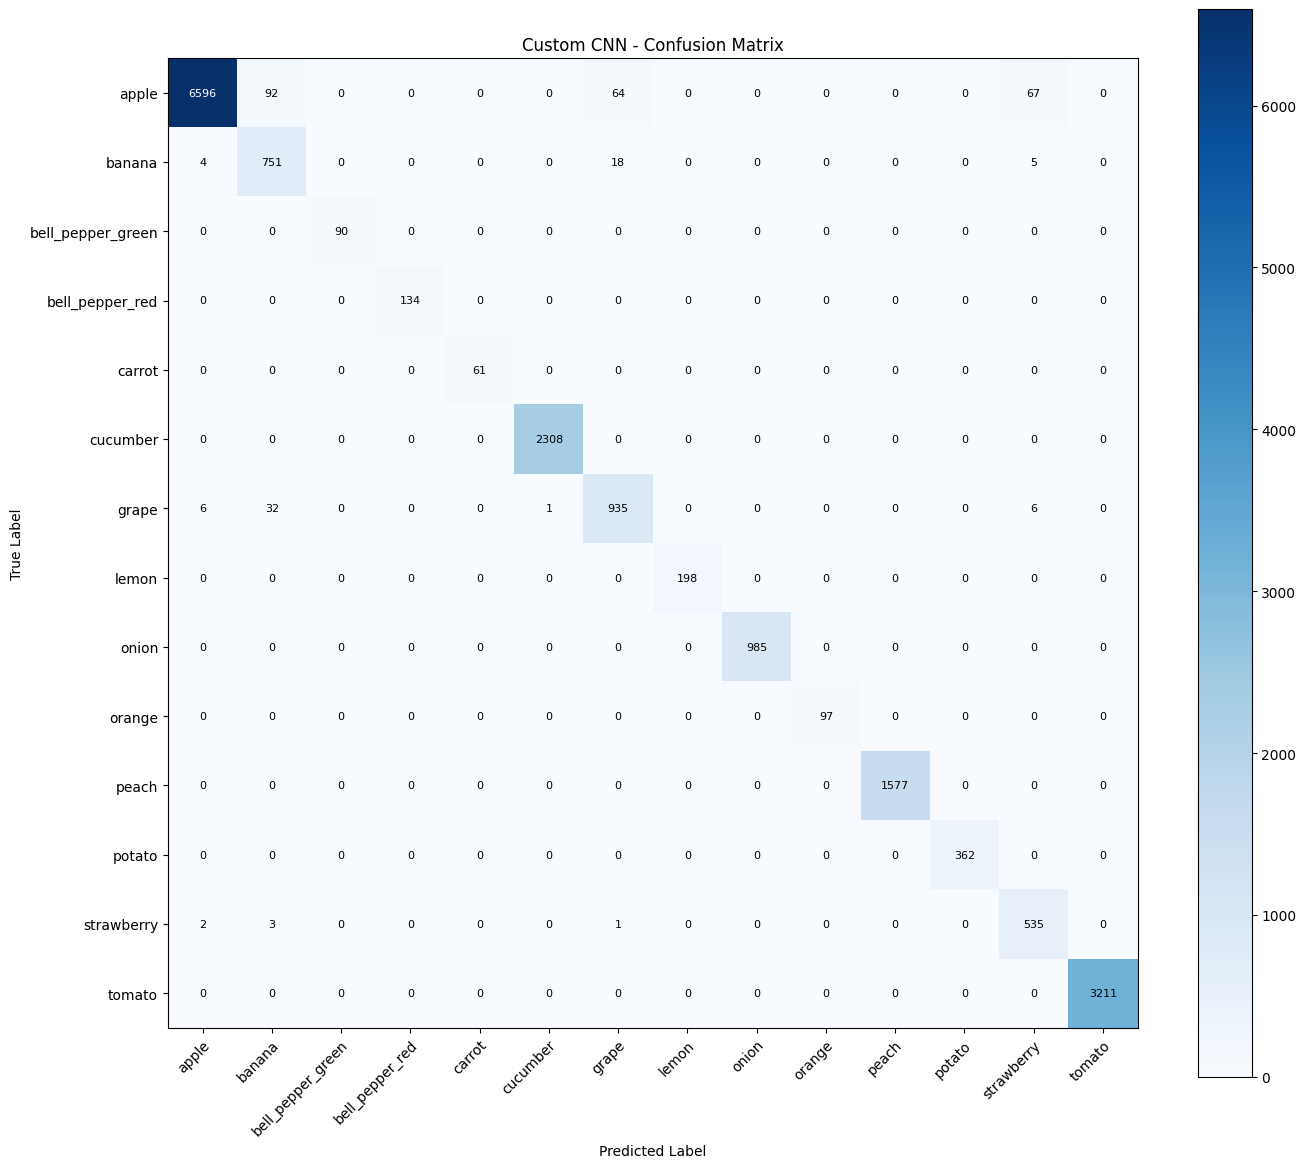


Saved: /content/custom_cnn_confusion_matrix.png


In [13]:
# ============================================================================
# CONFUSION MATRIX
# ============================================================================
# Visualises classification performance per class.
# ============================================================================

print("=" * 70)
print("CONFUSION MATRIX")
print("=" * 70)

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(14, 12))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(len(CLASS_NAMES)),
    yticks=np.arange(len(CLASS_NAMES)),
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    xlabel='Predicted Label',
    ylabel='True Label',
    title='Custom CNN - Confusion Matrix'
)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Add text annotations
thresh = cm.max() / 2.
for i in range(len(CLASS_NAMES)):
    for j in range(len(CLASS_NAMES)):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black',
                fontsize=8)

plt.tight_layout()
plt.savefig('/content/custom_cnn_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: /content/custom_cnn_confusion_matrix.png")

TRAINING HISTORY


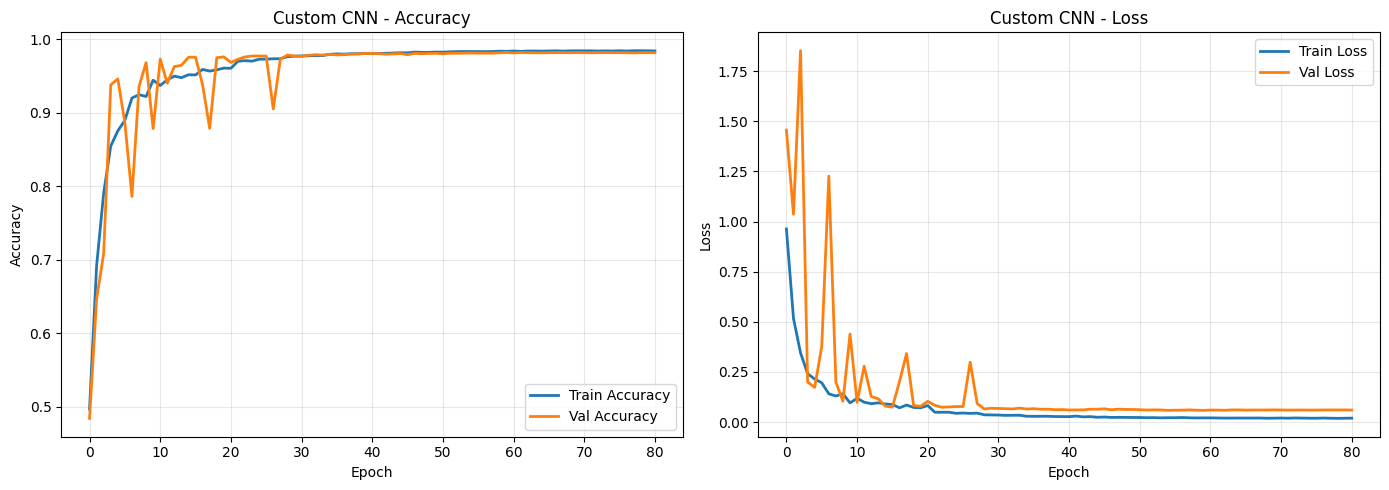


Saved: /content/custom_cnn_training_history.png

[Best Validation Performance]
  Epoch:    60
  Accuracy: 98.21%


In [14]:
# ============================================================================
# TRAINING HISTORY PLOTS
# ============================================================================
# Visualises accuracy and loss curves over ALL training epochs
# (including any resumed sessions).
# ============================================================================

print("=" * 70)
print("TRAINING HISTORY")
print("=" * 70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Custom CNN - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Custom CNN - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/custom_cnn_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: /content/custom_cnn_training_history.png")

# Print best metrics
best_epoch = np.argmax(history['val_accuracy']) + 1
best_val_acc = max(history['val_accuracy'])
print(f"\n[Best Validation Performance]")
print(f"  Epoch:    {best_epoch}")
print(f"  Accuracy: {best_val_acc*100:.2f}%")

In [15]:
# ============================================================================
# INFERENCE BENCHMARK
# ============================================================================
# Measures inference speed for single image and batch processing.
# ============================================================================

print("=" * 70)
print("INFERENCE BENCHMARK")
print("=" * 70)

# Create test batch
test_batch, _ = next(iter(test_generator))
single_image = test_batch[0:1]

# Warmup
for _ in range(5):
    _ = best_model.predict(single_image, verbose=0)

# Single image inference (100 iterations)
print("\nBenchmarking single image inference...")
times_single = []
for _ in range(100):
    start = time.time()
    _ = best_model.predict(single_image, verbose=0)
    times_single.append((time.time() - start) * 1000)

INFERENCE_TIME_SINGLE = np.mean(times_single)
INFERENCE_STD_SINGLE = np.std(times_single)

# Batch inference (32 images, 20 iterations)
print("Benchmarking batch inference...")
times_batch = []
for _ in range(20):
    start = time.time()
    _ = best_model.predict(test_batch, verbose=0)
    times_batch.append((time.time() - start) * 1000 / len(test_batch))

INFERENCE_TIME_BATCH = np.mean(times_batch)
INFERENCE_STD_BATCH = np.std(times_batch)

print(f"""
[Inference Results]
  Single Image:      {INFERENCE_TIME_SINGLE:.2f} +/- {INFERENCE_STD_SINGLE:.2f} ms
  Batch (per image): {INFERENCE_TIME_BATCH:.2f} +/- {INFERENCE_STD_BATCH:.2f} ms
""")

INFERENCE BENCHMARK

Benchmarking single image inference...
Benchmarking batch inference...

[Inference Results]
  Single Image:      64.97 +/- 2.75 ms
  Batch (per image): 7.09 +/- 6.22 ms



In [16]:
# ============================================================================
# SAVE MODEL AND RESULTS
# ============================================================================
# Saves final model and comprehensive results JSON for comparison.
# ============================================================================

print("=" * 70)
print("SAVING MODEL AND RESULTS")
print("=" * 70)

os.makedirs(DRIVE_MODEL_DIR, exist_ok=True)

# Save model
MODEL_SAVE_PATH = f"{DRIVE_MODEL_DIR}/custom_cnn_model.keras"
print(f"\nSaving model to: {MODEL_SAVE_PATH}")
best_model.save(MODEL_SAVE_PATH)
print("Model saved.")

model_size_mb = os.path.getsize(MODEL_SAVE_PATH) / (1024 * 1024)

# Compile results
results = {
    "model_name": "Custom CNN",
    "architecture": {
        "type": "Custom CNN (from scratch)",
        "conv_blocks": 4,
        "filters_per_block": [64, 128, 256, 512],
        "convs_per_block": 2,
        "pooling": "GlobalAveragePooling2D",
        "dense_units": 512,
        "dropout": 0.5,
        "activation": "relu",
        "input_size": list(IMG_SIZE),
        "num_classes": NUM_CLASSES
    },
    "training": {
        "total_epochs": len(history['loss']),
        "best_epoch": int(np.argmax(history['val_accuracy']) + 1),
        "training_time_seconds": TRAINING_TIME_SECONDS,
        "batch_size": BATCH_SIZE,
        "image_size": list(IMG_SIZE),
        "used_class_weights": True,
        "augmentation": AUGMENTATION_CONFIG,
        "pretrained": False
    },
    "performance": {
        "best_val_accuracy": float(max(history['val_accuracy'])),
        "test_accuracy": float(test_accuracy),
        "test_loss": float(test_loss)
    },
    "per_class_metrics": {
        class_name: {
            "precision": float(report_dict[class_name]["precision"]),
            "recall": float(report_dict[class_name]["recall"]),
            "f1_score": float(report_dict[class_name]["f1-score"]),
            "support": int(report_dict[class_name]["support"])
        }
        for class_name in CLASS_NAMES
    },
    "efficiency": {
        "total_parameters": int(total_params),
        "trainable_parameters": int(trainable_params),
        "model_size_mb": round(model_size_mb, 2),
        "inference_time_single_ms": round(INFERENCE_TIME_SINGLE, 2),
        "inference_time_batch_ms": round(INFERENCE_TIME_BATCH, 2)
    }
}

# Save results JSON
RESULTS_PATH = f"{DRIVE_MODEL_DIR}/custom_cnn_results.json"
print(f"\nSaving results to: {RESULTS_PATH}")
with open(RESULTS_PATH, 'w') as f:
    json.dump(results, f, indent=2)
print("Results saved.")

# Copy plots
print("\nCopying plots to Drive...")
shutil.copy('/content/custom_cnn_training_history.png', f"{DRIVE_MODEL_DIR}/custom_cnn_training_history.png")
shutil.copy('/content/custom_cnn_confusion_matrix.png', f"{DRIVE_MODEL_DIR}/custom_cnn_confusion_matrix.png")
print("Plots saved.")

SAVING MODEL AND RESULTS

Saving model to: /content/drive/MyDrive/snapshelf_models_v2/custom_cnn_model.keras
Model saved.

Saving results to: /content/drive/MyDrive/snapshelf_models_v2/custom_cnn_results.json
Results saved.

Copying plots to Drive...
Plots saved.


In [17]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("=" * 70)
print("CUSTOM CNN - FINAL SUMMARY")
print("=" * 70)

print(f"""
MODEL: Custom CNN
--------------------------------------------------
Type:           Custom CNN (trained from scratch)
Architecture:   VGG-style with 4 conv blocks
Filters:        64 -> 128 -> 256 -> 512
Convs/Block:    2
Pooling:        GlobalAveragePooling2D
Dense Units:    512
Dropout:        0.5
Pretrained:     No

TRAINING
--------------------------------------------------
Total Epochs:      {len(history['loss'])}
Best Epoch:        {np.argmax(history['val_accuracy']) + 1}
Training Time:     {training_duration}

PERFORMANCE
--------------------------------------------------
Validation Accuracy: {max(history['val_accuracy'])*100:.2f}%
Test Accuracy:       {test_accuracy*100:.2f}%
Test Loss:           {test_loss:.4f}

EFFICIENCY
--------------------------------------------------
Total Parameters:    {total_params:,}
Trainable Params:    {trainable_params:,}
Model Size:          {model_size_mb:.2f} MB
Inference (single):  {INFERENCE_TIME_SINGLE:.2f} ms
Inference (batch):   {INFERENCE_TIME_BATCH:.2f} ms/image

OUTPUT FILES
--------------------------------------------------
Model:   {MODEL_SAVE_PATH}
Results: {RESULTS_PATH}
Plots:   {DRIVE_MODEL_DIR}/custom_cnn_*.png
""")

print("=" * 70)
print("CUSTOM CNN TRAINING COMPLETE")
print("=" * 70)

CUSTOM CNN - FINAL SUMMARY

MODEL: Custom CNN
--------------------------------------------------
Type:           Custom CNN (trained from scratch)
Architecture:   VGG-style with 4 conv blocks
Filters:        64 -> 128 -> 256 -> 512
Convs/Block:    2
Pooling:        GlobalAveragePooling2D
Dense Units:    512
Dropout:        0.5
Pretrained:     No

TRAINING
--------------------------------------------------
Total Epochs:      81
Best Epoch:        60
Training Time:     17391s (289.8 min)

PERFORMANCE
--------------------------------------------------
Validation Accuracy: 98.21%
Test Accuracy:       98.34%
Test Loss:           0.0485

EFFICIENCY
--------------------------------------------------
Total Parameters:    4,964,942
Trainable Params:    4,960,078
Model Size:          56.92 MB
Inference (single):  64.97 ms
Inference (batch):   7.09 ms/image

OUTPUT FILES
--------------------------------------------------
Model:   /content/drive/MyDrive/snapshelf_models_v2/custom_cnn_model.keras
R